In [1]:
from helper import *
from math import log,pi
import numpy as np

inpu_data1 = read_input('NLS_Group05/Class1.txt')
inpu_data2 = read_input('NLS_Group05/Class2.txt')

train_data1,test_data1 = part_data(inpu_data1)
train_data2,test_data2 = part_data(inpu_data2)

train_data=[train_data1,train_data2]
test_data =[test_data1, test_data2]

mean1,variance1 = get_stats(train_data1)
mean2,variance2 = get_stats(train_data2)

total_test_data = test_data1+test_data2
total_train_data = train_data1+train_data2

cov1 = cov_matrix(train_data1,mean1)
cov2 = cov_matrix(train_data2,mean2)

In [2]:
import matplotlib.pyplot as plt
from math import log,exp
from matplotlib import style
style.use('fivethirtyeight')
# from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from scipy.stats import multivariate_normal
from math import pi
import time
from helper import *
import random
from scipy.cluster.vq import vq, kmeans, whiten
def prob(mu,cov,x):
#     print len(mu),len(cov_inv),len(x)
    reg_cov = 1e-6*np.ones([len(cov)])
    cov = np.add(cov, reg_cov)
    cov_inv = inverse_matrix(cov)
    diff = [np.subtract(x,mu)]
    
#     print diff,cov,cov_inv
    
    diff_T=np.array(diff).T
    res=matrix_multiply(diff,cov_inv)
    res=matrix_multiply(res,diff_T)
    res = res[0][0]

    exp_part = np.exp(res*0.5)
    pro=pow(get_determinant(cov),0.5)
    denom = pow(2*pi,len(cov[0])/2.0)*pro
    
    return(1.0/(exp_part*denom))

In [3]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=40):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):
        print "Starting K-means....with",self.k,"clusters...",self.max_iter,"iterations"
        self.centroids = {}
        
#         x_min, x_max = data[:,0].min(), data[:,0].max() 
#         y_min, y_max = data[:,1].min(), data[:,1].max()  
#         chuma = random.sample(range(len(data)), self.k)
        for i in range(self.k):
            self.centroids[i] = data[i]
#             self.centroids[i] = data[chuma[i]]
#         print "CENTROISS_____",self.centroids
        for ii in range(self.max_iter):
            
            print ii,
#             print "CENTROISS_____",self.centroids
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(np.array(featureset)-np.array(self.centroids[centroid])) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
#                 print "AXIS___",np.sum(self.classifications[classification],axis=0),np.mean(self.classifications[classification],axis=0),len(data)
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)
            
            total_error = 0.0
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                for jj in self.classifications[c]:
                    val1 = np.linalg.norm(jj-original_centroid)
                    val2 = np.linalg.norm(jj-current_centroid)
                    total_error += abs(val1-val2)
#                     print val1,val2,total_error
            
#             print total_error
            if (total_error<self.tol):
                print "K-means converged......"
                break
#             print self.centroids
#             return self.centroids, self.classifications

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification



class GMM:
    def __init__(self,X,number_of_sources,iterations,tolerence):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        self.tolerence = tolerence
        self.N = len(self.X)
        self.D = len(self.X[0])
        self.log_likelihoods = [] 
        self.data_clusters=[]
    
    """Define a function which runs for iterations, iterations"""
    def run(self):
        """ 1. Set the initial mu, covariance and pi values"""
        start=time.clock()
        clf = K_Means(self.number_of_sources)
        clf.fit(self.X)
        
#         print clf.centroids
        self.mu = np.array(clf.centroids.values())
        
            
        self.data_clusters = np.array(clf.classifications.values())
        
#         self.cov = np.array([np.zeros([self.D,self.D]) for cn in range(self.number_of_sources)])
#         print self.cov.shape, len(self.data_clusters), len(self.data_clusters[0])
        self.cov=[]
#         print self.mu
#         print "GVHGG________"
        for cn in range(self.number_of_sources):    
#             print len(self.data_clusters[cn]), self.mu[cn]
            covar=cov_matrix(self.data_clusters[cn], self.mu[cn])
#             print covar
#             for k in range(self.D):
            self.cov.append(covar)  # Inverse Covariance Matrix
#         print self.cov
            
        print "K-means Complete.... in",time.clock()-start,"sec"
        
        self.pi = np.ones(self.number_of_sources)/self.number_of_sources # Are "Fractions"
        for cn in range(self.number_of_sources):
            self.pi[cn] = len(self.data_clusters[cn])/(self.N*1.0)
        
        self.gamma = np.zeros((len(self.X),self.number_of_sources))
        
#         print self.pi
        """Plot the initial state"""  
        print "Starting GMM Iterations......."
        start=time.clock()
        
        reg_cov = 1e-6*np.identity(self.D)
#         print "HGJGJGJ____",reg_cov
#         reg_cov = np.fill_diagonal(reg_cov, 1e-6)
#         print "HGJGJGJ____",reg_cov
        
        
        for ii in range(self.iterations): 
            print ii,

            sum_denom = np.array([])
#             print "a",
            for i in range(self.N):
                temp = 0.0
                for j in range(self.number_of_sources):
#                     print temp,prob(self.mu[j],self.cov[j],self.X[i]),"........"
                    temp += self.pi[j]*prob(self.mu[j],self.cov[j],self.X[i])
                sum_denom = np.append(sum_denom,[temp])
#             print "b",
#             break
            for i in range(self.N):
                for j in range(self.number_of_sources):
                    self.gamma[i][j] = self.pi[j]*prob(self.mu[j],self.cov[j],self.X[i])
                    if(sum_denom[i]>0):
                        self.gamma[i][j] /= sum_denom[i]
            
#             print self.gamma
#             print "c",
            sum2 = []
            for i in range(self.number_of_sources):
                temp = 0.0
                for j in range(self.N):
                    temp += self.gamma[j][i]
                sum2.append(temp)
            
#             print sum2
#             print "d",
            for i in range(self.number_of_sources):
#                 print sum2[i],
                self.pi[i] = sum2[i]/len(self.X)
#             print "PI__K__", self.pi
#             print "e___HGDUGUD___",
#             print reg_cov
            for i in range(self.number_of_sources):
                tot = np.zeros([self.D, self.D])
                for j in range(self.N):
                    a = np.array([self.X[j] - self.mu[i]]).T
                    a_T=a.T
                    m=np.matmul(a,a_T)
#                     print i,j,a.shape,a_T.shape,m.shape, self.gamma[i][j]
                    m=np.multiply(self.gamma[j][i],m)
                    tot = np.add(tot, m)
                self.cov[i] = tot/(sum2[i]*1.0)
                self.cov[i] = np.add(self.cov[i], reg_cov)
            
#                 self.cov[i] = cov_diagonal(self.cov[i])
#             print "f",
            for i in range(self.number_of_sources):
                tot = np.zeros([self.D])
                for j in range(self.N):
                    tot += self.gamma[j][i] * self.X[j]
                self.mu[i] = tot/sum2[i]
#             print "g",
            chigg =0.0
            chi=0.0
            for i in range(len(self.X)):
                for j in range(self.number_of_sources):
#                     print i,j,self.pi[j],len(self.mu[j]),len(self.cov[j]),len(self.X[i])
                    chigg += self.pi[j] * prob(self.mu[j],self.cov[j],self.X[i])
                chi += np.log(chigg)
                
            self.log_likelihoods.append(chi)
#             print "h",
            try:
#                 print "---->",chi,chigg,abs(self.log_likelihoods[-1]-self.log_likelihoods[-2])
                if(abs(self.log_likelihoods[-1]-self.log_likelihoods[-2])<self.tolerence):
                    break
            except:
                pass
            
            """
            This process of E step followed by a M step is now iterated a number of n times. In the second step for instance,
            we use the calculated pi_new, mu_new and cov_new to calculate the new r_ic which are then used in the second M step
            to calculat the mu_new2 and cov_new2 and so on....
            """
        print "GMM complete in",time.clock()-start
    def predict2(self,Y):
        result = np.array([])
        for k in Y:
            tot = 0.0
            for i in range(self.number_of_sources):
                m = self.mu[i]
                c = self.cov[i]
                tot += self.pi[i]*prob(m,c,k)
            if(tot==0.):
                tot+=1e-6
            result=np.append(result,np.log(tot))
#             count+=1
        return result

In [4]:
legend_facecolor='#f6ffc6'
legend_edgecolor='#ff07ff'
legend_linewidth=2
legend_loc='upper right'

c={}
c[1]='#54bdff' # blue Class Color
c[2]='#9ef442' # green
c[3]='#FFB74D' # red

c2={}
c2[1]='#2205c4' # Training Points Color
c2[2]='#388E3C'
c2[3]='#ad061f'

Gmm started.... Starting K-means....with 1 clusters... 40 iterations
0 1 K-means converged......
K-means Complete.... in 0.031279 sec
Starting GMM Iterations.......
0 1 GMM complete in 0.196242
Gmm 1 done.... Starting K-means....with 1 clusters... 40 iterations
0 1 K-means converged......
K-means Complete.... in 0.032434 sec
Starting GMM Iterations.......
0 1 GMM complete in 0.196546
Gmm 2 done.... Predict 1 done... Predict 2 done... Confusion Matrix : [[188, 138], [132, 194]]
Accuracy : 0.585889570552
Precision :[0.5875, 0.5843373493975904] Mean Precision : 0.585918674699
Recall :[0.5766871165644172, 0.5950920245398773] Mean Recall : 0.585889570552
F-measure :[0.5820433436532507, 0.5896656534954408] Mean F-measure : 0.585854498574
Gmm started.... Starting K-means....with 2 clusters... 40 iterations
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 K-means converged......
K-means Complete.... in 0.292053 sec
Starting GMM Iterations.......
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

/home/prabhakar/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 GMM complete in 16.341827
Gmm 1 done.... Starting K-means....with 8 clusters... 40 iterations
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 K-means converged......
K-means Complete.... in 0.769484 sec
Starting GMM Iterations.......
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 GMM complete in 15.811361
Gmm 2 done.... Predict 1 done... Predict 2 done... Confusion Matrix : [[322, 4], [9, 317]]
Accuracy : 0.980061349693
Precision :[0.972809667673716, 0.9875389408099688] Mean Precision : 0.980174304242
Recall :[0.9877300613496932, 0.9723926380368099] Mean Recall : 0.980061349693
F-measure :[0.9802130898021308, 0.9799072642967542] Mean F-measure : 0.980060177049
Gmm started.... Starting K-means....with 16 clusters... 40 iterations
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 K-means converged......
K-means Complete.... in 2.573918 sec
Starting GMM Iterations.......
0 1 2 3 4 5 6 7 8 9 

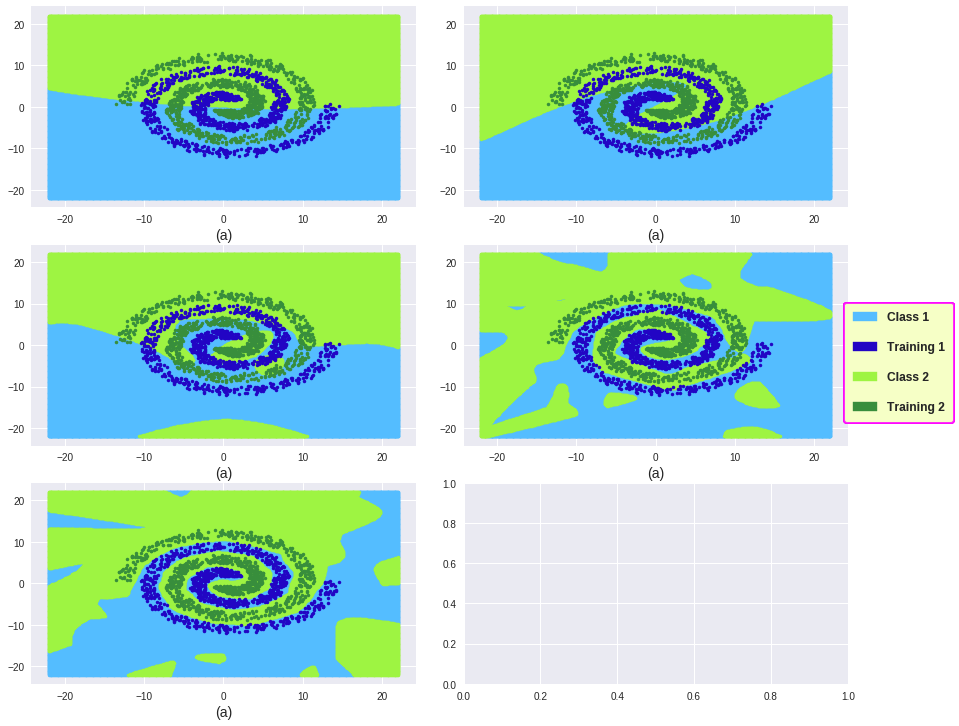

In [5]:
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.mlab as mlab
import pickle

matplotlib.style.use('seaborn')
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,14*0.89))

X=np.linspace(-22,22,400)
Y=np.linspace(-22,22,400)
XX=[]
YY=[]
for i in range(0, len(X)):
    for j in range(0, len(X)):
        XX.append(X[i])
for i in range(0, len(Y)):
    for j in range(0, len(Y)):
        YY.append(Y[j])
XY=[[XX[i],YY[i]] for i in range(0,len(XX))]

ni=25
to=0.001
acc=[]
for w in range(5):
    nc = pow(2,w)
    print "Gmm started....",
    g1=GMM(np.array(train_data1), nc,ni,to)
    g1.run()
    print "Gmm 1 done....",
    g2=GMM(np.array(train_data2), nc,ni,to)
    g2.run()
    print "Gmm 2 done....",
    
    
    with open('1b_g1_'+str(nc),'wb') as handle:
        pickle.dump(g1, handle)
    with open('1b_g2_'+str(nc),'wb') as handle:
        pickle.dump(g2, handle)
    
    
    test_data_name = XY
    res=[]
    res.append(g1.predict2(np.array(test_data_name)))
    print "Predict 1 done...",
    res.append(g2.predict2(np.array(test_data_name)))
    print "Predict 2 done...",
    
    x=[]
    y=[]
    for i in range(0,4):
        vv=[]
        v=[]
        x.append(v)
        y.append(vv)
    def db123():
        for i in range(0,len(res[0])):
            val=1
            if(res[1][i]>res[0][i]):
                val=2
            x[val].append(XY[i][0])
            y[val].append(XY[i][1])
    db123()
    
    with open('1b_real_x_'+str(nc),'wb') as handle:
        pickle.dump(x, handle)
    with open('1b_real_y_'+str(nc),'wb') as handle:
        pickle.dump(y, handle)
#     fig.suptitle('Dataset 3 (Real World Data) plots across Classes', fontsize=22)
    
    plt.subplot(321+w)
    plt.plot(x[1],y[1],c[1],marker='.',linestyle='None')
    plt.plot(x[2],y[2],c[2],marker='.',linestyle='None')

    X=[train_data1[i][0] for i in range(0,len(train_data1)) ]
    Y=[train_data1[i][1] for i in range(0,len(train_data1)) ]
    plt.plot(X,Y,c=c2[1],marker='.',linestyle='None')

    X=[train_data2[i][0] for i in range(0,len(train_data2)) ]
    Y=[train_data2[i][1] for i in range(0,len(train_data2)) ]
    plt.plot(X,Y,c=c2[2],marker='.',linestyle='None')

#     plt.title('Class1 vs Class2', fontsize=16)
    
    colors = [c[1],c2[1],c[2],c2[2]]
    texts = ["Class 1","Training 1", "Class 2", "Training 2"]
    
    handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i  in range(len(texts))]
    legend=fig.legend(handles=handles, labels=texts,loc='right', ncol=1,frameon=1,
                      labelspacing=1.5, borderpad=0.75, prop=dict(weight='black',size='large'))
    
    frame = legend.get_frame()
    frame.set_facecolor(legend_facecolor)
    frame.set_edgecolor(legend_edgecolor)
    frame.set_linewidth(legend_linewidth)
#     #     plt.show()
    co=[c[1], c[2], c[3]]
    co2=[c2[1], c2[2], c2[3]]
    plt.xlabel('(a)',fontsize=14)
    
    def stat():
        test_data_name = total_test_data
        res1=g1.predict2(np.array(test_data_name))
        res2=g2.predict2(np.array(test_data_name))
        def dbb():
            ans=[]
            for i in range(0,len(res1)):
                val=1
                if(res2[i]>res1[i]):
                    val=2
                ans.append(val)
            return ans
        ans= dbb()
        def conf_mat():
            m=[]
            count1=0
            count2=0
            for i in range(0, len(test_data1)):
                if(ans[i]==1):
                    count1 = count1+1;
            for i in range(len(test_data1), len(total_test_data)):
                if(ans[i]==2):
                    count2 = count2+1;
            mm=[count1,len(test_data1)-count1]
            m.append(mm)
            mm=[len(test_data2)-count2, count2]
            m.append(mm)
            return m

        m=conf_mat()
        accuracy=(sum([m[i][i] for i in range(0,2)]))/(float)(sum([sum(m[i]) for i in range(0,2)]))
        precision=[m[i][i]/(float)(m[0][i]+m[1][i]) for i in range(0,2)]
        recall=[m[i][i]/(float)(m[i][0]+m[i][1]) for i in range(0,2)]
        f_measure=[(2*precision[i]*recall[i])/(precision[i]+recall[i]) for i in range(0,2)]

        mean_precision=sum([precision[i] for i in range(0,2)])/2.0
        mean_recall=sum([recall[i] for i in range(0,2)])/2.0
        mean_f_measure=sum([f_measure[i] for i in range(0,2)])/2.0

        print "Confusion Matrix : {0}".format(m)
        print "Accuracy :",accuracy
        print "Precision :{0}".format(precision),"Mean Precision :",mean_precision
        print "Recall :{0}".format(recall),"Mean Recall :",mean_recall
        print "F-measure :{0}".format(f_measure),"Mean F-measure :",mean_f_measure
        acc.append([nc,accuracy])

        with open('1b_real_stats_'+str(nc),'wb') as handle:
            handle.write("Confusion Matrix : {0}\n".format(m))
            handle.write("Accuracy : "+str(accuracy)+"\n")
            handle.write("Precision :{0}".format(precision)+"\nMean Precision : "+str(mean_precision)+"\n")
            handle.write("Recall :{0}".format(recall)+"\nMean Recall : "+str(mean_recall)+"\n")
            handle.write("F-measure :{0}".format(f_measure)+"\nMean F-measure : "+str(mean_f_measure)+"\n")
    stat()
with open('1b_acc','wb') as handle:
    pickle.dump(acc, handle)
print "\n\n";
plt.subplots_adjust(right=0.89,wspace=0.125, hspace=0.185)

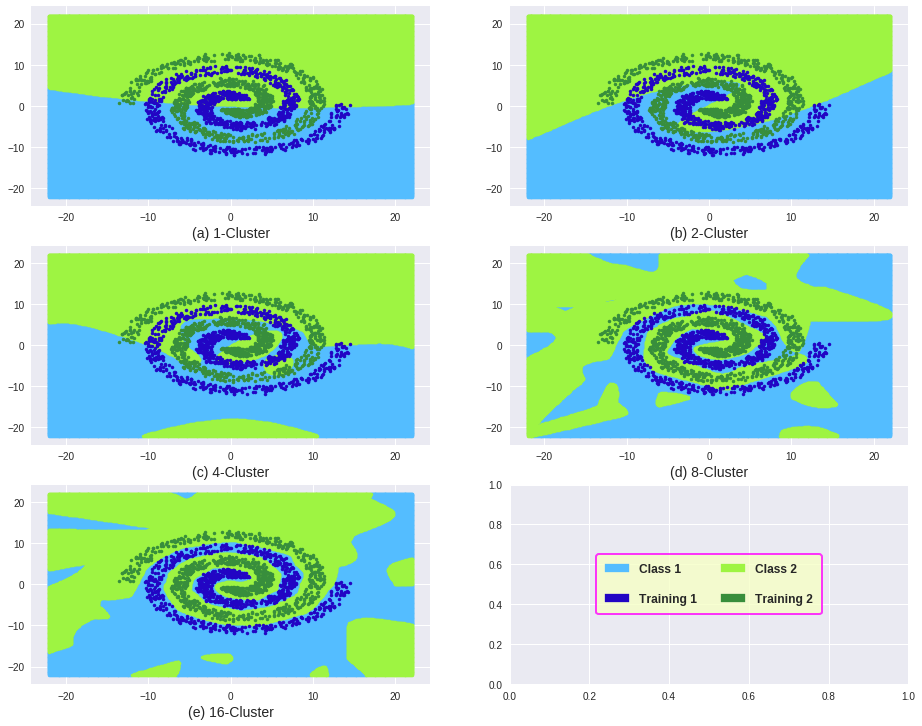

In [6]:
# matplotlib.style.use('seaborn')
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,14*0.89))
for w in range(5):
    nc = pow(2,w)
    with open('1b_real_x_'+str(nc),'rb') as handle:
        x=pickle.loads(handle.read())
    with open('1b_real_y_'+str(nc),'rb') as handle:
        y=pickle.loads(handle.read())
    
    plt.subplot(321+w)
    l1=plt.plot(x[1],y[1],c[1],marker='.',linestyle='None')
    l2=plt.plot(x[2],y[2],c[2],marker='.',linestyle='None')
    
#     l3=plt.plot(x[3],y[3],c[3],marker='.',linestyle='None')
    X=[train_data1[i][0] for i in range(0,len(train_data1)) ]
    Y=[train_data1[i][1] for i in range(0,len(train_data1)) ]
    l4=plt.plot(X,Y,c=c2[1],marker='.',linestyle='None')
    
    X=[train_data2[i][0] for i in range(0,len(train_data2)) ]
    Y=[train_data2[i][1] for i in range(0,len(train_data2)) ]
    l5=plt.plot(X,Y,c=c2[2],marker='.',linestyle='None')
    
    colors = [c[1],c2[1],c[2],c2[2],c[3],c2[3]]
    texts = ["Class 1","Training 1", "Class 2", "Training 2"]
    handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i  in range(len(texts))]
    legend=ax6.legend(handles=handles, labels=texts,loc='center', ncol=2,frameon=1, 
                      labelspacing=1.5, borderpad=0.75, prop=dict(weight='black',size='large'))
    frame = legend.get_frame()
    frame.set_facecolor(legend_facecolor)
    frame.set_edgecolor(legend_edgecolor)
    frame.set_linewidth(legend_linewidth)
        #     plt.show()
    co=[c[1], c[2], c[3]]
    co2=[c2[1], c2[2], c2[3]]
    ad=ord('a')+w
    plt.xlabel('('+chr(ad)+') '+str(nc)+'-Cluster',fontsize=14)
plt.show()

/home/prabhakar/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
/home/prabhakar/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.


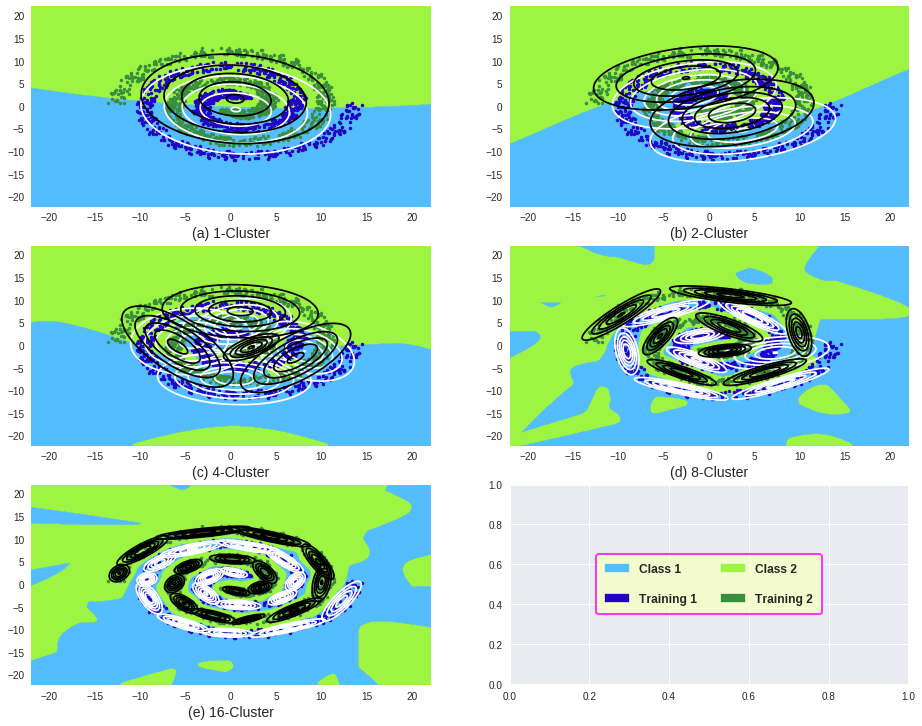

In [7]:
# matplotlib.style.use('seaborn')
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,14*0.89))
for w in range(5):
    nc = pow(2,w)
    
    with open('1b_real_x_'+str(nc),'rb') as handle:
        x=pickle.loads(handle.read())
        
    with open('1b_real_y_'+str(nc),'rb') as handle:
        y=pickle.loads(handle.read())
    
    with open('1b_g1_'+str(nc),'rb') as handle:
        g1=pickle.loads(handle.read())
    
    with open('1b_g2_'+str(nc),'rb') as handle: 
        g2=pickle.loads(handle.read())
    
    plt.subplot(321+w)
    l1=plt.plot(x[1],y[1],c[1],marker='.',linestyle='None')
    l2=plt.plot(x[2],y[2],c[2],marker='.',linestyle='None')

    X=[train_data1[i][0] for i in range(0,len(train_data1)) ]
    Y=[train_data1[i][1] for i in range(0,len(train_data1)) ]
    l4=plt.plot(X,Y,c=c2[1],marker='.',linestyle='None')
    X=[train_data2[i][0] for i in range(0,len(train_data2)) ]
    Y=[train_data2[i][1] for i in range(0,len(train_data2)) ]
    l5=plt.plot(X,Y,c=c2[2],marker='.',linestyle='None')
    
    
    delta = 0.025*100
    xu=np.linspace(-22,22,400)
    yu=np.linspace(-22,22,400)
    XI, YI = np.meshgrid(xu, yu)
    for i in range(g1.number_of_sources):
        cov__=g1.cov[i]
        sigmax1=pow(cov__[0][0],0.5)
        sigmay1=pow(cov__[1][1],0.5)
        mux1=g1.mu[i][0]
        muy1=g1.mu[i][1]
        sigmaxy1 = cov__[0][1]
        ZI1 = mlab.bivariate_normal(XI, YI, sigmax1, sigmay1, mux1, muy1,sigmaxy1)
        plt.contour(XI, YI, ZI1,5,zorder=10,colors="white")
    
    for i in range(g1.number_of_sources):
        cov__=g2.cov[i]
        sigmax2=pow(cov__[0][0],0.5)
        sigmay2=pow(cov__[1][1],0.5)
        mux2=g2.mu[i][0]
        muy2=g2.mu[i][1]
        sigmaxy2 = cov__[0][1]
        ZI2 = mlab.bivariate_normal(XI, YI, sigmax2, sigmay2, mux2, muy2,sigmaxy2)
        plt.contour(XI, YI, ZI2,5,zorder=10,colors="k")
    
#     plt.title('Class1 vs Class2 vs Class3', fontsize=14)
    colors = [c[1],c2[1],c[2],c2[2],c[3],c2[3]]
    texts = ["Class 1","Training 1", "Class 2", "Training 2"]
    handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i  in range(len(texts))]
    legend=ax6.legend(handles=handles, labels=texts,loc='center', ncol=2,frameon=1, 
                      labelspacing=1.5, borderpad=0.75, prop=dict(weight='black',size='large'))
    frame = legend.get_frame()
    frame.set_facecolor(legend_facecolor)
    frame.set_edgecolor(legend_edgecolor)
    frame.set_linewidth(legend_linewidth)
        #     plt.show()
    co=[c[1], c[2], c[3]]
    co2=[c2[1], c2[2], c2[3]]
    ad=ord('a')+w
    plt.xlabel('('+chr(ad)+') '+str(nc)+'-Cluster',fontsize=14)
plt.show()

/home/prabhakar/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
/home/prabhakar/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.


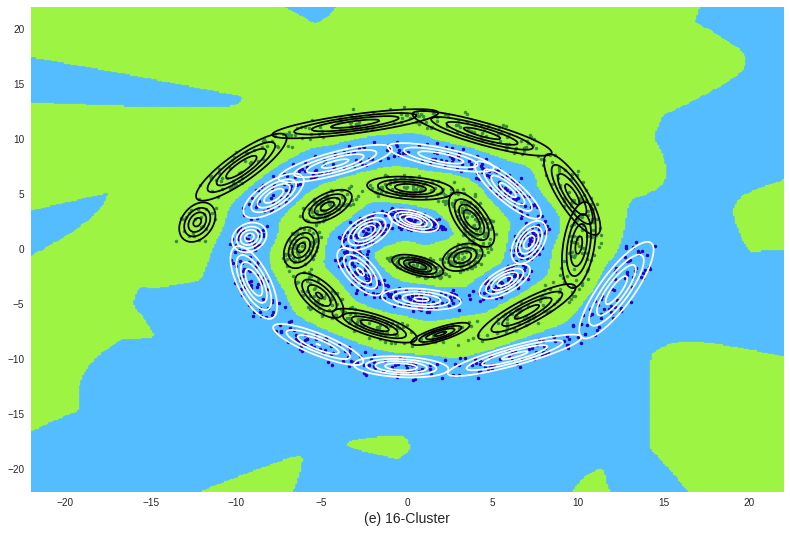

In [8]:
# matplotlib.style.use('seaborn')
fig, (ax1) = plt.subplots(1, 1, figsize=(12,10*0.89))
for w in range(4,5):
    nc = pow(2,w)
    
    with open('1b_real_x_'+str(nc),'rb') as handle:
        x=pickle.loads(handle.read())
        
    with open('1b_real_y_'+str(nc),'rb') as handle:
        y=pickle.loads(handle.read())
    
    with open('1b_g1_'+str(nc),'rb') as handle:
        g1=pickle.loads(handle.read())
    
    with open('1b_g2_'+str(nc),'rb') as handle: 
        g2=pickle.loads(handle.read())
    
    l1=plt.plot(x[1],y[1],c[1],marker='.',linestyle='None')
    l2=plt.plot(x[2],y[2],c[2],marker='.',linestyle='None')

    X=[train_data1[i][0] for i in range(0,len(train_data1)) ]
    Y=[train_data1[i][1] for i in range(0,len(train_data1)) ]
    l4=plt.plot(X,Y,c=c2[1],marker='.',linestyle='None')
    
    X=[train_data2[i][0] for i in range(0,len(train_data2)) ]
    Y=[train_data2[i][1] for i in range(0,len(train_data2)) ]
    l5=plt.plot(X,Y,c=c2[2],marker='.',linestyle='None')
    
    
    delta = 0.025*100
    xu=np.linspace(-22,22,400)
    yu=np.linspace(-22,22,400)
    XI, YI = np.meshgrid(xu, yu)
    for i in range(g1.number_of_sources):
        cov__=g1.cov[i]
        sigmax1=pow(cov__[0][0],0.5)
        sigmay1=pow(cov__[1][1],0.5)
        mux1=g1.mu[i][0]
        muy1=g1.mu[i][1]
        sigmaxy1 = cov__[0][1]
        ZI1 = mlab.bivariate_normal(XI, YI, sigmax1, sigmay1, mux1, muy1,sigmaxy1)
        plt.contour(XI, YI, ZI1,4,zorder=10,colors="white")
    
    for i in range(g1.number_of_sources):
        cov__=g2.cov[i]
        sigmax2=pow(cov__[0][0],0.5)
        sigmay2=pow(cov__[1][1],0.5)
        mux2=g2.mu[i][0]
        muy2=g2.mu[i][1]
        sigmaxy2 = cov__[0][1]
        ZI2 = mlab.bivariate_normal(XI, YI, sigmax2, sigmay2, mux2, muy2,sigmaxy2)
        plt.contour(XI, YI, ZI2,4,zorder=10,colors="k")
    
#     plt.title('Class1 vs Class2 vs Class3', fontsize=14)
    colors = [c[1],c2[1],c[2],c2[2],c[3],c2[3]]
    texts = ["Class 1","Training 1", "Class 2", "Training 2"]
    handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i  in range(len(texts))]
    legend=ax6.legend(handles=handles, labels=texts,loc='center', ncol=2,frameon=1, 
                      labelspacing=1.5, borderpad=0.75, prop=dict(weight='black',size='large'))
    frame = legend.get_frame()
    frame.set_facecolor(legend_facecolor)
    frame.set_edgecolor(legend_edgecolor)
    frame.set_linewidth(legend_linewidth)
        #     plt.show()
    co=[c[1], c[2], c[3]]
    co2=[c2[1], c2[2], c2[3]]
    ad=ord('a')+w
    plt.xlabel('('+chr(ad)+') '+str(nc)+'-Cluster',fontsize=14)
plt.show()

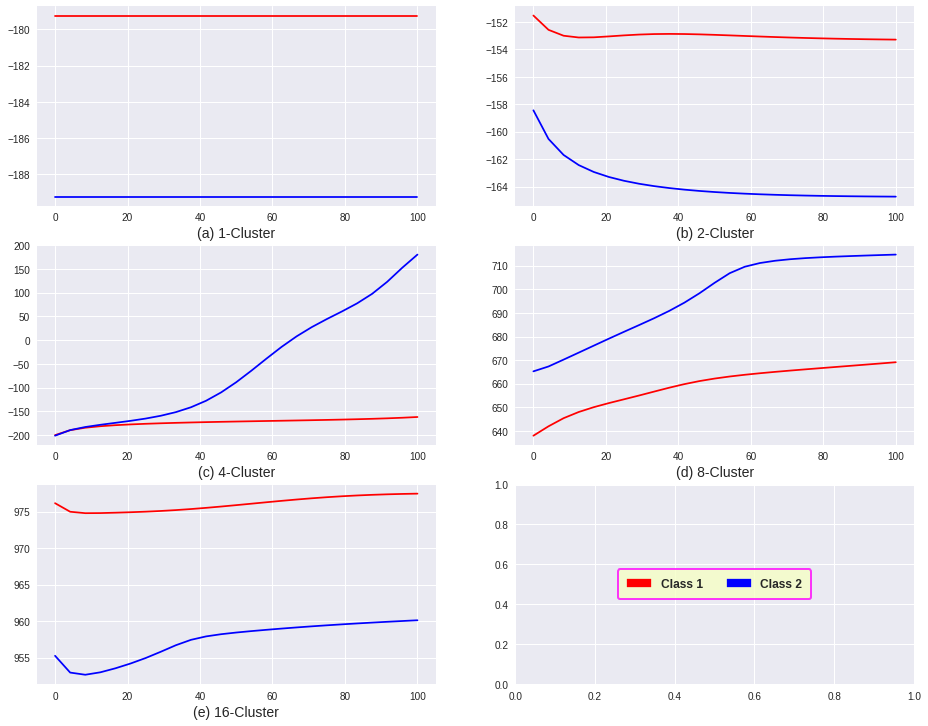

In [14]:
# matplotlib.style.use('seaborn')
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,14*0.89))
for w in range(5):
    nc = pow(2,w)
    plt.subplot(321+w)
    with open('1b_g1_'+str(nc),'rb') as handle:
        g1=pickle.loads(handle.read())
        xx=np.linspace(0,100,len(g1.log_likelihoods))
        plt.plot(xx,g1.log_likelihoods,c='r')
        
    with open('1b_g2_'+str(nc),'rb') as handle: 
        g2=pickle.loads(handle.read())
        xx=np.linspace(0,100,len(g2.log_likelihoods))
        plt.plot(xx,g2.log_likelihoods,c='b')
    
#     plt.title('Class1 vs Class2 vs Class3', fontsize=14)
    colors = ['r','b',c[2],c2[2],c[3],c2[3]]
    texts = ["Class 1", "Class 2"]
    handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i  in range(len(texts))]
    legend=ax6.legend(handles=handles, labels=texts,loc='center', ncol=2,frameon=1, 
                      labelspacing=1.5, borderpad=0.75, prop=dict(weight='black',size='large'))
    frame = legend.get_frame()
    frame.set_facecolor(legend_facecolor)
    frame.set_edgecolor(legend_edgecolor)
    frame.set_linewidth(legend_linewidth)
        #     plt.show()
    co=[c[1], c[2], c[3]]
    co2=[c2[1], c2[2], c2[3]]
    ad=ord('a')+w
    plt.xlabel('('+chr(ad)+') '+str(nc)+'-Cluster',fontsize=14)
plt.show()

[[1, 0.5858895705521472], [2, 0.558282208588957], [4, 0.6625766871165644], [8, 0.9800613496932515], [16, 1.0]]


Text(0,0.5,'Accuracy')

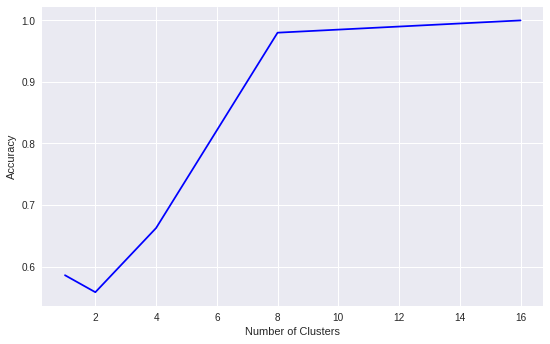

In [10]:
print acc
X=[acc[i][0] for i in range(0,len(acc)) ]
Y=[acc[i][1] for i in range(0,len(acc)) ]
plt.plot(X,Y,c='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')